# Mutation Risk

In [1]:
from utils import analysis, plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import importlib
importlib.reload(plotting)

burn_in = 0.2

In [243]:
data_name = "G13_LUAD_12"

samples = np.load("../results/mcmc/G13_LUAD_12_sym-l2_MALA_0_0015625.npy" if data_name == "G13_LUAD_12"
                  else "../results/mcmc/G13_COAD_12_symsparse_MALA_0_001.npy")[:, ::10]
samples = samples[int(len(samples)*burn_in):]
samples = samples.reshape((-1, samples.shape[-1]))

data = pd.read_csv(f"../data/{data_name}.csv", index_col=0)

In [244]:
risks = analysis.event_risks(
    samples,
    data=data,
    n_samples=100
)

Text(0.5, 0.98, 'Mutation risk estimates for G13_LUAD_12, symsparse')

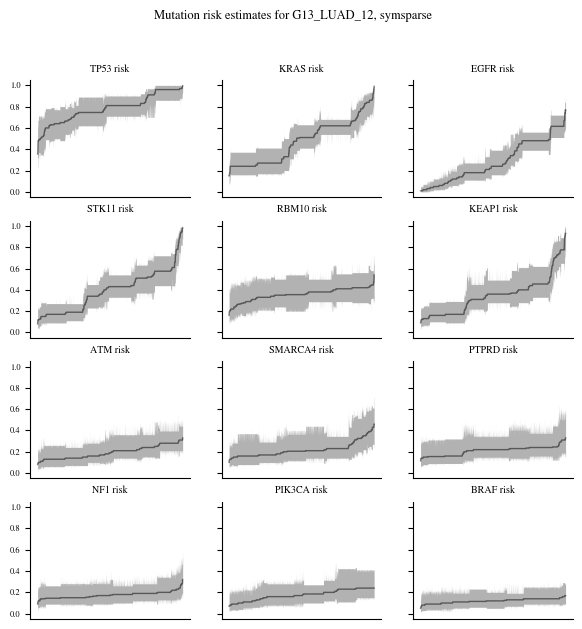

In [245]:
fig, ax = plt.subplots(4, 3, figsize=(7, 7), sharey=True)

for event in range(12):
    
    a = ax[event // 3, event % 3]
    
    data_filtered = data.reset_index(drop=True)[data.reset_index(drop=True).iloc[:, event] == 0]
    sorting = None

    risk = risks[data_filtered.index, :, event]
    sorting = np.argsort(np.median(risk, axis=1))
    a.plot(np.median(risk, axis=1)[sorting], lw=1, alpha=0.5, color="black")
    a.fill_between(
        np.arange(risk.shape[0]),
        np.percentile(risk, 5, axis=1)[sorting],
        np.percentile(risk, 95, axis=1)[sorting],
        alpha=0.3, color="black", lw=0)
    a.set_title(f"{data.columns[event]} risk")
    for side in ["top", "right"]:
        a.spines[side].set_visible(False)
    a.set_xticks([])
fig.suptitle(f"Mutation risk estimates for {data_name}, symsparse", fontsize=9)

## Association of Mutation Risk with Patient Survival

In [246]:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival

In [247]:
survival = pd.read_table("../data/msk_chord_2024_clinical_data.tsv",
                         index_col="Sample ID",
                         usecols=[
                             "Overall Survival Status",
                             "Overall Survival (Months)",
                             "Sample ID"])
survival.index = survival.index.map(lambda x: "GENIE-MSK-" + x)
survival = survival[survival.index.isin(data.index)]
survival["Overall Survival Status"] = survival["Overall Survival Status"].apply(
    lambda x: bool(x[0]))

In [248]:
filter_immuno = True

if filter_immuno:
    treatment = pd.read_table("../data/data_timeline_treatment.txt")
    treatment = treatment.groupby("PATIENT_ID")["SUBTYPE"].apply(
        lambda x: (x == "Immuno").any())
    treatment = pd.DataFrame(treatment)
    survival = survival.loc[[sample for sample in survival.index if sample[10:19]
                             in treatment.index and treatment.loc[sample[10:19]].all()]]

In [249]:
filter_kras = False

if filter_kras:
    survival = survival.loc[[sample for sample in survival.index if sample
                             if data.loc[sample]["KRAS"] == 1]]

In [250]:
if data_name == "G13_LUAD_12":
    event = "STK11"
    thresholds = (0.2, 0.8)
elif data_name == "G13_COAD_12":
    event = "ARID1A"
    thresholds = (0.2, 0.8)
else:
    raise ValueError("Unknown data_name")

i_event = data.columns.get_loc(event)

c_low_risk = "#036D51"
c_medium_risk = "#BB9D3A"
c_high_risk = "#9B1818"
highlight_params = {
    "hatch": "//////",
    "alpha": 0.4,
    "fc": "white",
    "hatch_linewidth": 1
}

def assign_group(val):
    if val > thresholds[1]:
        return "High"
    elif val > thresholds[0]:
        return "Medium"
    elif val <= thresholds[0]:
        return "Low"
    elif pd.isna(val):
        return "Present"
    else:
        raise ValueError("Unexpected value")

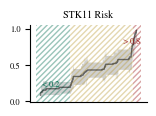

In [251]:
fig, ax = plt.subplots(figsize=(1.5, 1))

data_filtered = data.reset_index(
    drop=True)[data.reset_index(drop=True).iloc[:, i_event] == 0]
risk = risks[data_filtered.index, :, i_event]
sorting = np.argsort(np.median(risk, axis=1))

ax.plot(np.median(risk, axis=1)[sorting], lw=1, alpha=0.5, color="black")
ax.fill_between(
    np.arange(risk.shape[0]),
    np.percentile(risk, 5, axis=1)[sorting],
    np.percentile(risk, 95, axis=1)[sorting],
    alpha=0.3, color="black", lw=0)
x_lims = ax.get_xlim()
low_risk_end = np.where(np.median(risk, axis=1)[sorting] < thresholds[0])[0]
if len(low_risk_end) == 0:
    low_risk_end = x_lims[0]
else:
    low_risk_end = low_risk_end.max()
high_risk_start = np.where(np.median(risk, axis=1)[sorting] > thresholds[1])[0].min()

ax.axvspan(x_lims[0], low_risk_end, **
            highlight_params, color=c_low_risk, lw=0)
ax.axvspan(low_risk_end, high_risk_start, **
            highlight_params, color=c_medium_risk, lw=0)
ax.axvspan(high_risk_start, x_lims[1], **
            highlight_params, color=c_high_risk, lw=0)
ax.set_title(f"{event} Risk")
if low_risk_end > x_lims[0]:
    ax.text(0.1 * x_lims[1], thresholds[0], f"$<{thresholds[0]}$",
           ha="center", color=c_low_risk)
ax.text(0.9 * x_lims[1], thresholds[1], f"$>{thresholds[1]}$", ha="center",
           color=c_high_risk)
for side in ["top", "right"]:
    ax.spines[side].set_visible(False)
_ = ax.set_xticks([])

fig.savefig(
    f"../results/figs/{data_name}_{event.lower()}_risk.pdf",
)

In [240]:
risk_survival = pd.DataFrame(np.median(risks[:, :, i_event], axis=1),
                             index=data.index, columns=["median_risk"])
risk_survival = risk_survival.merge(
    survival, left_index=True, right_index=True)
risk_survival = risk_survival.loc[[
    i for i in risk_survival.index if data[event][i] == 0]]
risk_survival["group"] = risk_survival["median_risk"].apply(assign_group)

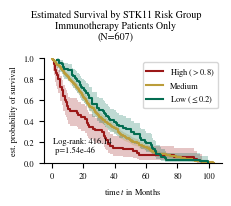

In [230]:
fig, ax = plt.subplots(figsize=(2.3, 2))

for color, group_label in zip([c_high_risk, c_medium_risk, c_low_risk], ("High", "Medium", "Low")):

    if group_label not in risk_survival["group"].values:
        continue

    patients = risk_survival[risk_survival["group"] == group_label]
    time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
        patients["Overall Survival Status"],
        patients["Overall Survival (Months)"],
        conf_type="log-log",
    )

    if group_label == "High":
        group_label += f" ($> {thresholds[1]}$)"
    elif group_label == "Low":
        group_label += f" ($\\leq {thresholds[0]}$)"

    ax.step(time_treatment, survival_prob_treatment,
            where="post", label=group_label, color=color)
    ax.fill_between(
        time_treatment, conf_int[0], conf_int[1],
        alpha=0.25, step="post", color=color, lw=0)

log_rank, p = compare_survival(
    risk_survival[["Overall Survival Status", "Overall Survival (Months)"]]
    .to_records(index=False),
    risk_survival["median_risk"],
)

ax.text(0.6, 0.1, f"Log-rank: {log_rank:.2f}\n p={p:.2e}")
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.set_ylim(0, 1)
ax.set_ylabel("est. probability of survival")
ax.set_xlabel("time $t$ in Months")
ax.legend(loc="best")
fig.suptitle(f"Estimated Survival by {event} Risk Group"
             + ("\n" if (filter_immuno or filter_kras) else "")
             + ("Immunotherapy " if filter_immuno else "") 
             + ("KRAS-positive " if filter_kras else "")
             + ("Patients Only" if filter_immuno or filter_kras else "")
             + f"\n(N={len(risk_survival)})"
             )
fig.tight_layout()
fig.savefig(
    f"../results/figs/{data_name}_{event.lower()}_survival{('_immuno' if filter_immuno else '')}{('_kras' if filter_kras else '')}.pdf", dpi=300)

## Risks Predicted by the Different Modes of the L1 Posteriors

In [202]:
import umap
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA

2026-02-02 07:54:50.419112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-02 07:54:50.564990: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-02 07:54:50.568943: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-02-02 07:54:50.568964: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [203]:
data_name = "G13_LUAD_12"

samples = np.load("../results/mcmc/G13_LUAD_12_l1_MALA_0_001.npy" if data_name == "G13_LUAD_12"
                  else "../results/mcmc/G13_COAD_12_l1_MALA_0_001421875.npy")[:, ::10]
samples = samples[int(len(samples)*burn_in):]
samples = samples.reshape((-1, samples.shape[-1]))

data = pd.read_csv(f"../data/{data_name}.csv", index_col=0)

In [204]:
n_components = 3
clusterable_embedding = umap.UMAP(
    n_components=n_components).fit_transform(samples)
labels = HDBSCAN(
    min_samples=10,
    min_cluster_size=100,
).fit_predict(clusterable_embedding)
standard_embedding = PCA(n_components=n_components).fit_transform(samples)
clustered = (labels >= 0)

In [205]:
unique_labels = np.unique(labels)
unique_labels = unique_labels[unique_labels != -1]

In [206]:
risks = {
    label: analysis.event_risks(
        samples[labels == label],
        data=data,
        n_samples=100
    )
    for label in np.unique(labels) if label != -1
}

Text(0.5, 0.98, 'Mutation risk estimates for G13_LUAD_12')

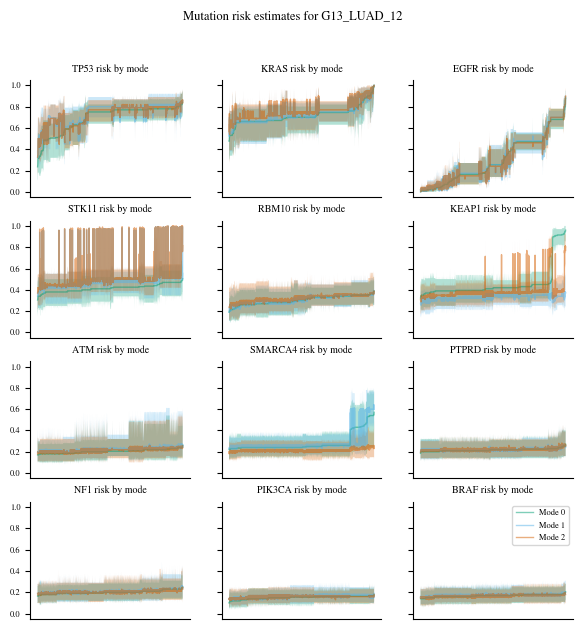

In [210]:
fig, ax = plt.subplots(4, 3, figsize=(7, 7), sharey=True)

for event in range(12):
    
    a = ax[event // 3, event % 3]
    
    data_filtered = data.reset_index(drop=True)[data.reset_index(drop=True).iloc[:, event] == 0]
    sorting = None

    for label in unique_labels:
        

        risk = risks[label][data_filtered.index, :, event]
        if label == -1:
            continue
        if sorting is None:
            sorting = np.argsort(np.median(risk, axis=1))
        a.plot(np.median(risk, axis=1)[sorting], label=f"Mode {label}", lw=1, alpha=0.5)
        a.fill_between(
            np.arange(risk.shape[0]),
            np.percentile(risk, 5, axis=1)[sorting],
            np.percentile(risk, 95, axis=1)[sorting],
            alpha=0.3,)
    a.set_title(f"{data.columns[event]} risk by mode")
    for side in ["top", "right"]:
        a.spines[side].set_visible(False)
    a.set_xticks([])
ax[-1, -1].legend()
fig.suptitle(f"Mutation risk estimates for {data_name}", fontsize=9)
    
